In [1]:
import fiftyone as fo
import pandas as pd
import numpy as np
import math 

# Notebook to split the dataset using different approaches 
See https://esmartcontrol.atlassian.net/wiki/spaces/ES/pages/2342420485/YoloV5+Multitasks#Data-splits

In [2]:
dataset = fo.load_dataset("esmart_wip")


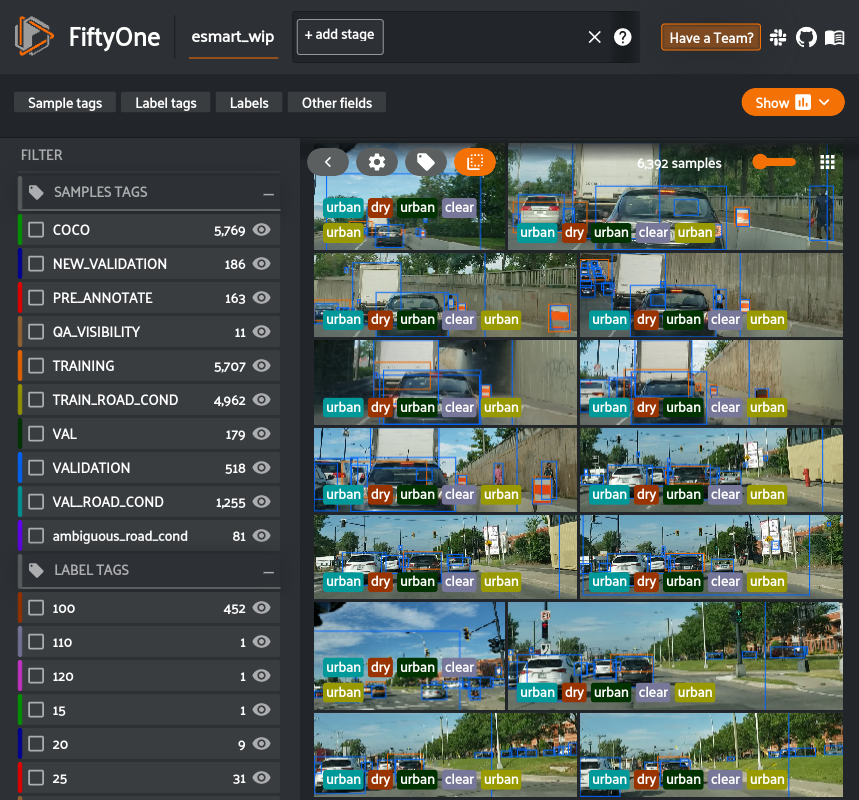

Dataset:          esmart_wip
Media type:       image
Num samples:      6392
Selected samples: 0
Selected labels:  0
Session URL:      http://localhost:5151/

In [3]:
fo.launch_app(dataset)

In [190]:
def analyze_sequences_fiftyone():
    """Analyze the different sequences in the 51 dataset 
    Returns a df with a count of frames per sequence.
    """
    filepath_list = []
    seq_list = []
    frame_list = []
    for sample in dataset:
        file_path = sample.filepath
        file_name = sample.filepath.split("/")[-1]
#         print(file_name)
        file_name_splitted = file_name.split("_")
#         print(file_name_splitted)
        sequence_ls = file_name_splitted[:-1]
        sequence = "".join(map(str, sequence_ls))
        frame = file_name_splitted[-1].split(".")[:-1]
        filepath_list.append(file_path)
        seq_list.append(sequence)
        frame_list.append(frame)
#         break
    sequences_tuples = list(zip(filepath_list, seq_list, frame_list))
    sequences_df = pd.DataFrame(sequences_tuples, columns=["Filepath", "Sequence", "Frame"])
#     sequences_df.sort_values(["Sequence", "Frame"], inplace=True)
#     print(sequences_df.groupby(["Sequence"]).count().shape)
# convert the frame id from a list of string to an integer
    sequences_df['Frame'] = sequences_df['Frame'].apply(lambda x: int(x[0]))
    sequences_df_grouped = sequences_df.groupby(["Sequence"]).count()
    return sequences_df

In [191]:
sequences_df = analyze_sequences_fiftyone()

In [192]:
sequences_df

,Filepath,Sequence,Frame
0,/home/admin/data/esmart_wip/20210629_173500_11...,20210629173500,11004
1,/home/admin/data/esmart_wip/20210629_173500_11...,20210629173500,11010
2,/home/admin/data/esmart_wip/20210629_173500_11...,20210629173500,11232
3,/home/admin/data/esmart_wip/20210629_173500_11...,20210629173500,11856
4,/home/admin/data/esmart_wip/20210629_173500_12...,20210629173500,12156
...,...,...,...
6387,/home/raphael/esmart/esmart-ai-datasets/data/e...,Log-20220326-183856 Data Log,4872
6388,/home/raphael/esmart/esmart-ai-datasets/data/e...,Log-20220326-183856 Data Log,4968
6389,/home/raphael/esmart/esmart-ai-datasets/data/e...,Log-20220326-183856 Data Log,5176
6390,/home/raphael/esmart/esmart-ai-datasets/data/e...,Log-20220326-183856 Data Log,5368


## 1. Split manually by selecting some validation sequences -- OOD

In [ ]:
def split_train_val_fiftyone_sequences():
    """
    Split the dataset by sequence number (by manually inspecting the properties of the sequences).
    Allows to not have frames from the same sequence in both the training and validation set.
    This is crucial to check whether the algorithm is performant in "new scenes" and doesn't 
    just learns spurrious correlations. 
    """
    list_sequences_val_set = [
        "Log-20220123-124034 Data Log",  # for some snowy and/or wet
        "Log-20220130-104657 Data Log",  # for some snowy and/or wet
        "Log-20220120-181824 Data Log",  # for some snowy and/or wet
        "20210630191429",  # for some dry
        "20210630180005",  # for some dry
        "20210630192517",  # for some dry
        "20211129193841",  # for some dry
        "20210715091801",  # for some dry
        "20211129205422",  # for some dry
        "20210724133321",  # for some dry
        "20210715175810",  # for some dry
        "20210630195611",  # for some dry
        "20210630191006",  # for some dry
    ]

    counter_train = {}
    counter_train["wet"] = 0
    counter_train["dry"] = 0
    counter_train["snowy"] = 0

    counter_val = {}
    counter_val["wet"] = 0
    counter_val["dry"] = 0
    counter_val["snowy"] = 0

    for sample in dataset:
        try:
            condition = sample.gt_road_condition.classifications[0].label
            seq = str(sample.tags[-1])
            if seq in list_sequences_val_set:
                counter_val[condition] += 1
                sample.tags.append("VAL_ROAD_COND")
                sample.save()
            else:
                condition = sample.gt_road_condition.classifications[0].label
                counter_train[condition] += 1
                sample.tags.append("TRAIN_ROAD_COND")
                sample.save()
        except:
            a = 1
    print("TRAIN ", counter_train)
    print("train total", sum(counter_train.values()))
    print("VAL ", counter_val)
    print("val total", sum(counter_val.values()))

if SPLIT_TRAIN_VAL_IN_51:
    split_train_val_fiftyone_sequences()

## 2. Use Subsequences for splitting -- ID

In [193]:
def check_time_between_2_frames(frame_1, frame_2, num_minutes):
    """
    Function to check whether 2 frames can be used in 2 data sets.
    e.g We want frame_1 in the training set and frame_2 in the validation set. We need to make 
    sure that these are not too close to each other in terms of time otherwise they could be very
    similar and the validation set would be biased. This is not the perfect technique to check the
    independence between frames but that's an approach.
    args: 
        the frame numbers from a same sequence 
        the number of minutes that we want between 2 frames to consider them as "far enough"
            from eaach other (independent enough).
    returns:
        True if we can use these 2 images in 2 sets
        False otherwise
    """
    assert type(frame_1) == type(frame_2) == np.int64
    num_frame_btw = abs(frame_2 - frame_1)
    # approximation
    threshold = num_minutes * 60 * 24
#     print("The chosen time as threshold is", num_minutes,"minutes.")
#     print("There must be at least", threshold,"frames between 2 images to split these in 2 sets.")
    if num_frame_btw >= threshold:
        return True 
    else:
        return False 

In [194]:
# get all the different sequence names
sequences_names = sequences_df['Sequence'].unique()
print("There is", len(sequences_names), "sequences.")

There is 53 sequences.


In [230]:
num_minutes_threshold = 2

empty_list = list(zip([],[],[],[]))
frames_splitted_df = pd.DataFrame(empty_list, columns=["Filepath", "Sequence", "Frame","Set"])

frames_splitted_df

for seq in sequences_names:
    # loc all the rows of a specific sequence
    sequence = sequences_df.loc[sequences_df['Sequence'] == seq].sort_values(['Frame'], 
                                                                             ignore_index=True)
    num_frames = sequence.shape[0]
    print("The sequence", seq, "contains", num_frames, "frames.")
    max_index_training_set = math.floor(num_frames * 0.7)-1  # 70 % of the frames in this data 
    sequence['Set'] = 0
    sequence.loc[:max_index_training_set, 'Set'] = 'train'
    found_first_index_val_set = False
    i = 1
    frame_1 = sequence['Frame'][max_index_training_set]
    print("The maximum index for the train set is", max_index_training_set,". It's the frame", frame_1)
    # print("Frame 1:",frame_1)
    index = max_index_training_set + 1
    while not found_first_index_val_set and index < num_frames:
        frame_2 = sequence['Frame'][index]
        found_first_index_val_set = check_time_between_2_frames(frame_1, frame_2, num_minutes_threshold)
        if found_first_index_val_set:
            min_index_val_set = index
            print("The minimum index for the validation set is", min_index_val_set,". It's the frame", frame_2)
            sequence.loc[min_index_val_set:, 'Set'] = 'val'
            break
        i += 1
        index += i
    if not found_first_index_val_set:
        print("No minimum index found. Try reducing the percentage of data in the training set or the time threshold.")
    frames_to_concat = [frames_splitted_df, sequence]
    frames_splitted_df = pd.concat(frames_to_concat)
    print()

The sequence 20210629173500 contains 103 frames.
The maximum index for the train set is 71 . It's the frame 8442
The minimum index for the validation set is 99 . It's the frame 13326

The sequence 20210629174553 contains 114 frames.
The maximum index for the train set is 78 . It's the frame 17061
The minimum index for the validation set is 99 . It's the frame 24183

The sequence 20210630055611 contains 226 frames.
The maximum index for the train set is 157 . It's the frame 17304
The minimum index for the validation set is 172 . It's the frame 20943

The sequence 20210630083253 contains 265 frames.
The maximum index for the train set is 184 . It's the frame 36222
The minimum index for the validation set is 212 . It's the frame 40755

The sequence 20210630175841 contains 3 frames.
The maximum index for the train set is 1 . It's the frame 570
No minimum index found. Try reducing the percentage of data in the training set or the time threshold.

The sequence 20210630180005 contains 27 fram

In [231]:
assert frames_splitted_df.shape[0] == sequences_df.shape[0]

In [279]:
frames_splitted_df

,Filepath,Sequence,Frame,Set
0,/home/admin/data/esmart_wip/20210629_173500_20...,20210629173500,2034,train
1,/home/admin/data/esmart_wip/20210629_173500_20...,20210629173500,2064,train
2,/home/admin/data/esmart_wip/20210629_173500_21...,20210629173500,2100,train
3,/home/admin/data/esmart_wip/20210629_173500_22...,20210629173500,2214,train
4,/home/admin/data/esmart_wip/20210629_173500_22...,20210629173500,2256,train
...,...,...,...,...
69,/home/raphael/esmart/esmart-ai-datasets/data/e...,Log-20220121-143049 Data Log,9656,0
70,/home/raphael/esmart/esmart-ai-datasets/data/e...,Log-20220121-143049 Data Log,9749,0
71,/home/raphael/esmart/esmart-ai-datasets/data/e...,Log-20220121-143049 Data Log,9873,0
72,/home/raphael/esmart/esmart-ai-datasets/data/e...,Log-20220121-143049 Data Log,10214,0


In [266]:
count_split = frames_splitted_df['Set'].value_counts()
df_count = pd.DataFrame(count_split).transpose()
df_count.rename(columns={'train':'Training set', 'val':'Validation set', 0:'Left out'}, inplace=True)

In [275]:
df_count

,Training set,Validation set,Left out
Set,4451,1156,785


In [277]:
import plotly.express as px
fig = px.bar(df_count, title='Distribution of the new data split')
fig.show()

### Save splits in fiftyone

In [323]:
# training/validation road condition automatic bsed on time 
mapping = {'train':'TRAIN_RC_AUTO_TIME', 'val':'VAL_RC_AUTO_TIME'} 
for sample in dataset:
    data_set = str(list(frames_splitted_df[frames_splitted_df['Filepath'] == sample.filepath]['Set'])[0])
#     print(data_set)
    if data_set != '0':
        sample.tags.append(mapping[data_set])
#         print(sample.tags)
        sample.save()

## Delete splits in fiftyone (if needed sometimes)

In [322]:
to_check = list(mapping.values())
for sample in dataset:
    for item in to_check:
        if item in sample.tags:
            sample.tags.remove(str(item))
    sample.save()

['COCO', 'TRAIN_ROAD_COND', 'TRAINING']
VAL_RC_AUTO_TIME
['COCO', 'TRAIN_ROAD_COND', 'TRAINING']
